### Task
Binary classification of error-related potentials (ErrP) vs non-ErrP from EEG epochs to generalize across subjects.

### Labels
y = 1 : ErrP (error trials)
y = 0 : Non-ErrP (correct trials)

### Data split policy
Subject-wise split: no subject appears in more than one of {train, val, test}.
All preprocessing statistics (mean/std, scalers) computed on train only, applied to val/test.

### Metrics
ROC-AUC, Accuracy, TPR/TNR and confusion matrix

In [1]:
import sys
print(sys.executable)

/home/dhl638/miniforge3/envs/RNN_ErrP_Deland/bin/python


In [2]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import multiprocessing
import optuna
from optuna.trial import TrialState
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from optuna.pruners import MedianPruner
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score
import time
from optuna.samplers import RandomSampler
import h5py
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from dataclasses import dataclass, field
from typing import Tuple
import random
import torch.nn.functional as F
from IPython.display import display, Markdown, HTML


/home/dhl638/miniforge3/envs/RNN_ErrP_Deland/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [103]:
#Config parameters

@dataclass(frozen=True)
class PipelineConfig:
    small_sample_size_experiment: bool = False
    small_sample_size: int=20000
    use_multiple_datesets: bool = False
    use_perceptual_dataset: bool = True
    use_neuromod_dataset: bool = False
    spatial_filter_use: bool = False
    normalization: bool = False
    val_ratio: float= 0.2
    test_ratio: float=0.2
    train_ratio: float = 0.6
    epochOnset: int=256
    fs: int = 512
    t_start: float = -0.5
    t_end: float = 1.0
    baseline_start: float= -0.2
    baseline_end:float= -0.1
    rejection_threshold = 150
    unique_magnitudes: Tuple[int, ...] = (0, 3, 6, 9, 12)
    RNN_features_PL_dataset: Tuple[int, ...] = (4,8,10,14,18,20,24)
    RNN_features_neuromod_dataset: Tuple[int, ...] = (5,9,10,15,20,21,25)
    #"ErrPDetectionRNNModel_with_att"
    model_name: str = "ErrPDetectionRNNModel_with_att"
    Optuna_folder: str = "optuna/ErrPDetectionRNNModel_with_att"
    #Set random seeds for reproducibility
    sampler_seed: int = 40
    n_optuna_trials: int = 50
    batch_size: int =  32


parameters = PipelineConfig()
number_of_features = len(parameters.RNN_features_neuromod_dataset)
time_stamps = np.arange(parameters.t_start, parameters.t_end, 1/parameters.fs)



# Dataset loading

In [4]:
# Dataset loading
import gc
def deref_all_refs(group, ref_container):
    return [group[ref[0]][:] for ref in ref_container]

def load_combined_data():
    """
    Reads 'combinedEpochs_v2.mat' (HDF5) and concatenates trials across subjects.
    
    Returns
    -------
    rotation_dataset_all_subjects : np.ndarray [sequence length, channels, num trials], EEG data
    labels_all_subjects           : np.ndarray [1, num trials], Trial-level labels (e.g., error vs correct). 
    magnitudes_all_subjects       : np.ndarray [1, num trials], Trial-level magnitudes [0,3,6,9,12]
    subjects_index                : np.ndarray [1, num trials], subject IDs
    """

    with h5py.File('data/combinedEpochs_v2.mat', 'r') as bci_file:
        bci_group = bci_file['combinedEpochs']

        #De-reference
        all_data_refs = deref_all_refs(bci_group, bci_group['rotation_data'])
        all_label_refs = deref_all_refs(bci_group, bci_group['label'])
        all_magnitude_refs = deref_all_refs(bci_group, bci_group['magnitude'])
    
        number_of_subjects = len(all_data_refs)
        number_of_trials =  all_data_refs[0].shape[0]
        print('number of subjects:', len(all_data_refs))
        print('checking shape of one subject:', all_data_refs[0].shape)
    
        # Cast to float32 to reduce memory
        rotation_dataset = [ref[:].astype(np.float32) for ref in all_data_refs]
        labels = [ref[:].astype(np.uint8) for ref in all_label_refs]
        magnitudes = [ref[:].astype(np.uint8) for ref in all_magnitude_refs]
    
        # Clean up refs
        del all_data_refs, all_label_refs, all_magnitude_refs
        gc.collect()
    
        # Concatenate
        rotation_dataset_all_subjects = np.squeeze(np.concatenate(rotation_dataset, axis=0))
        labels_all_subjects = np.squeeze(np.concatenate(labels, 1))
        magnitudes_all_subjects = np.squeeze(np.concatenate(magnitudes, 1))
        subjects_index = np.arange(1,number_of_subjects+1)
        subjects_index = np.squeeze(np.repeat(subjects_index, number_of_trials))
    
        print('entire dataset: EEG shape:', rotation_dataset_all_subjects.shape)
        print('entire dataset: labels shape:', labels_all_subjects.shape)
        print('entire dataset: magnitudes shape:', magnitudes_all_subjects.shape)
        print('entire dataset: subjects index shape:', subjects_index.shape)
    
        return rotation_dataset_all_subjects, labels_all_subjects, magnitudes_all_subjects, subjects_index

In [5]:
# Grand average plotting of error and correct trials

def GA_plotting(data, labels, channel, magnitudes, unique_magnitudes, b_start, b_end, time_stamps):
    """
    GA_plotting: Plot the grand-average (GA) EEG waveform for a given channel across different error magnitudes.

    Args:
        data: np.ndarray [sequence length, channels, num trials], EEG data
        labels: np.ndarray [num trials], Trial-level labels (e.g., error vs correct)
        channel: int, channel to plot
        magnitudes: np.ndarray [num trials]
        unique_magnitudes: np.ndarray [0, 3, 6, 9, 12]
        b_start: float, baseline start timestamp
        b_end: float, baseline end timestamp
        time_stamps: np.ndarray, time vector in seconds

    Returns:
        <brief>
    """
    bmask = (time_stamps >= b_start) & (time_stamps <= b_end)
    #baseline normalization
    data = data[:,channel,:]- data[:,channel,bmask].mean(axis=1, keepdims=True)

    #plot the GA of each magnitude
    for mag in unique_magnitudes:
        mask = np.squeeze(magnitudes == mag)
        plt.plot(time_stamps, np.mean(data[mask,:], axis=0), label=f'magnitude = {int(mag)}')
        
    plt.axvline(0, color='k', linestyle=':', linewidth=1)
    plt.xlabel('time [s]')
    plt.ylabel('amplitude [uV]')
    plt.legend()
    plt.show()


number of subjects: 16
checking shape of one subject: (1984, 32, 768)
entire dataset: EEG shape: (31744, 32, 768)
entire dataset: labels shape: (31744,)
entire dataset: magnitudes shape: (31744,)
entire dataset: subjects index shape: (31744,)


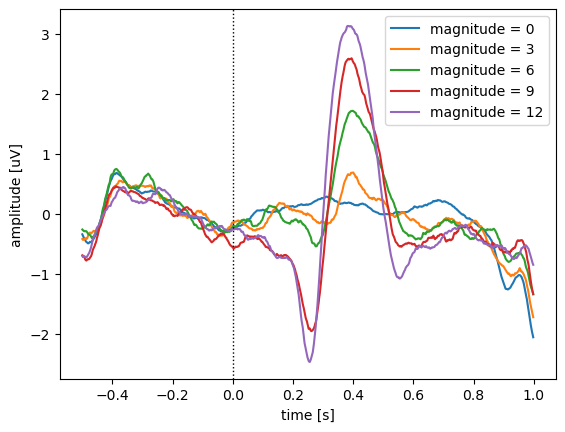

In [7]:
#GA visualization
rotation_dataset_all_subjects, labels_all_subjects, magnitudes_all_subjects, subjects_index= load_combined_data()
GA_plotting(rotation_dataset_all_subjects, labels_all_subjects, 15, magnitudes_all_subjects, parameters.unique_magnitudes, parameters.baseline_start, parameters.baseline_end, time_stamps)

# Preprocessing

In [6]:
#Basic preprocessing: sequence rejection via amplitude thresholding

def sequence_rejection(data, labels, magnitudes, task_labels, subjects_index, threshold):
    """
     Reject EEG trials whose signal amplitude exceeds a given threshold, 
    and return the cleaned dataset with aligned labels and indices.

    Args:    
        data         : np.ndarray [sequence length, channels, num trials], EEG data
        labels       : np.ndarray [num trials], Trial-level labels (e.g., error vs correct)
        magnitudes   : np.ndarray [num trials], Trial-level magnitudes
        task_labels  : np.ndarray [num trials]
        subjects_index : np.ndarray num trials], Subject IDs corresponding to each trial
        threshold    : float, Amplitude cutoff for trial rejection

    Returns cleaned data. Labels, magnitudes, task labels and subject_indices aligned with kept trials
    """
    
    trials = data.shape[2]
    keep_mask = np.ones(trials, dtype=bool)
    for trial_id in range(trials):
        #trial rejection via amplitude thresholding
        if np.any(data[:,:, trial_id] > threshold):
            keep_mask[trial_id] = False
    cleaned_data = data[:,:,keep_mask]
    cleaned_labels = labels[keep_mask].reshape(-1, 1)
    cleaned_magnitudes = magnitudes[keep_mask].reshape(-1, 1)
    cleaned_task_labels = task_labels[keep_mask].reshape(-1, 1)
    cleaned_subjects_index = subjects_index[keep_mask].reshape(-1, 1)
    return cleaned_data, cleaned_labels, cleaned_magnitudes, cleaned_task_labels, cleaned_subjects_index

In [7]:
#Basic preprocessing: Spatial filtering to increase spatial resolution
def spatial_filter(data):
    """
    Apply common average referencing (CAR) spatial filter to EEG data.

    Args:
        data : np.ndarray [sequence length, channels, num trials], EEG data

    Returns:
        np.ndarray: Data of the same shape, where for each time point and trial, 
                    the channel-wise mean has been subtracted.
    """

    return data - np.mean(data, axis=1, keepdims=True)

In [8]:
#Basic preprocessing: baseline normalization
def baseline_normalize(data, time_stamps, baseline_start, baseline_end):
    """
    Baseline-correct EEG data by subtracting the mean amplitude 
    within a baseline time window for each trial.

    Args:
        data : np.ndarray [sequence length, channels, num trials], EEG data
        time_stamps : np.ndarray [sequence length] Time vector corresponding to the data’s time dimension (in seconds).
        baseline_start : float, Start time (in seconds) of the baseline interval.
        baseline_end : float, End time (in seconds) of the baseline interval.

    Returns:
        np.ndarray: Baseline-normalized data of the same shape as input, 
                    where each trial and channel has its mean amplitude 
                    in the baseline window subtracted across time.
    """
    #baseline extract
    bmask = (time_stamps >= baseline_start) & (time_stamps <= baseline_end)
    #baseline normalization
    baseline_normalized_data = data - np.mean(data[:,:,bmask], axis=2, keepdims=True)
    
    return baseline_normalized_data

# Dataset creation and splitting

In [9]:
#PyTorch Dataset for single trial ErrP sequences

class ErrPDataset(Dataset):
    """
    Custom PyTorch Dataset for error-related potential (ErrP) sequences.

    Args
    ----
    sequences   : np.ndarray [num_trials, seq_len, num_features]
                  EEG data
    labels      : np.ndarray [num_trials]
                  Binary (0/1) sequence-level labels.
    magnitudes  : np.ndarray [num_trials]
                  Perturbation magnitudes per trial.
    task_labels : np.ndarray [num_trials]
                  Task condition identifiers per trial.
    subjects_index : np.ndarray [num_trials]
                     Subject IDs corresponding to each trial.

    Returns
    -------
    dict with:
        features       : torch.FloatTensor [seq_len, num_features]
        labels         : torch.LongTensor [1]
        magnitudes     : torch.LongTensor [1]
        task_labels    : torch.LongTensor [1]
        subjects_index : torch.LongTensor [1]
    """
    def __init__(self, sequences, labels, magnitudes, task_labels, subjects_index):
        self.sequences = sequences  # [num trials, seq_len, num_features]
        self.labels = labels        # [num_trials], sequence level classification
        self.magnitudes = magnitudes # [num_trials]
        self.task_labels = task_labels  # [num_trials]
        self.subjects_index = subjects_index  # [num_trials]
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        # map numpy arrays to tensors
        return {'features': torch.tensor(self.sequences[idx], dtype=torch.float), \
                'labels': torch.tensor(self.labels[idx], dtype=torch.long), \
               'magnitudes': torch.tensor(self.magnitudes[idx], dtype=torch.long), \
               'task_labels': torch.tensor(self.task_labels[idx], dtype=torch.long), \
                'subjects_index': torch.tensor(self.subjects_index[idx], dtype=torch.long)
               }


In [97]:
#Split data into train/val/test with no leakage.
def Dataset_splitting(tensor_data, train_ratio, val_ratio, test_ratio):
    """
    Split dataset into subject-independent train/val/test sets.

    Args
    ----
    tensor_data : ErrPDataset
    train_ratio : float
                  Proportion of subjects assigned to training split.
    val_ratio   : float
                  Proportion of subjects assigned to validation split.
    test_ratio  : float
                  Proportion of subjects assigned to test split.

    Returns
    -------
    train_set : list of dict
        List of trial dictionaries (same format as ErrPDataset __getitem__).
    dict with:
        features       : torch.FloatTensor [seq_len, num_features]
        labels         : torch.LongTensor [1]
        magnitudes     : torch.LongTensor [1]
        task_labels    : torch.LongTensor [1]
        subjects_index : torch.LongTensor [1]
        
    test_set  : list of dict
        Test split.
    val_set   : list of dict
        Validation split.
    """
    
    subjects = np.unique(tensor_data.subjects_index)
    #np.random.shuffle(subjects)
    train_set_subjects = subjects[:int(len(subjects) * train_ratio)]
    val_set_subjects = subjects[int(len(subjects) * train_ratio):int(len(subjects) * (train_ratio + val_ratio))]
    test_set_subjects =np.setdiff1d(subjects, np.concatenate((train_set_subjects, val_set_subjects)))

    #Subject-level data splitting
    print('subjects in test group:', test_set_subjects)
    print('subjects in train group:',train_set_subjects)
    print('subjects in val group:',val_set_subjects)
    train_mask = np.isin(tensor_data.subjects_index,train_set_subjects)
    test_mask = np.isin(tensor_data.subjects_index,test_set_subjects)
    val_mask = np.isin(tensor_data.subjects_index,val_set_subjects)
    train_indices = np.where(train_mask)[0]
    val_indices   = np.where(val_mask)[0]
    test_indices  = np.where(test_mask)[0]
    train_set = [tensor_data[x] for x in train_indices]
    val_set = [tensor_data[x] for x in val_indices]
    test_set = [tensor_data[x] for x in test_indices]
    
    return train_set, val_set, test_set



In [11]:
# collate_fn to turn a list of sample dicts into batch tensors

def collate_fn(batch):
    """
    Custom collate function to batch trial dictionaries into tensors.

    Args
    ----
    batch : list of dict
        Each dict is one trial (output of ErrPDataset __getitem__).

    Returns
    -------
    sequences      : torch.FloatTensor [batch_size, seq_len, num_features]
    labels         : torch.LongTensor [batch_size]
    magnitudes     : torch.LongTensor [batch_size]
    task_labels    : torch.LongTensor [batch_size]
    subjects_index : torch.LongTensor [batch_size]
    """

    #batch trial dictionaries into tensors.
    sequences = [x['features'] for x in batch]
    labels = [x['labels'] for x in batch]
    magnitudes = [x['magnitudes'] for x in batch]
    task_labels = [x['task_labels'] for x in batch]
    subjects_index = [x['subjects_index'] for x in batch]
    return torch.stack(sequences), torch.stack(labels), torch.stack(magnitudes), torch.stack(task_labels), torch.stack(subjects_index)

In [12]:
#Create Dataloaders

def create_dataloaders(train_data, val_data, test_data, size, n_workers, collate_fn):
    """
    Create PyTorch DataLoaders for train/val/test splits.

    Args
    ----
    train_data : list of dict
                 Training set (output of Dataset_splitting).
    val_data   : list of dict
                 Validation set.
    test_data  : list of dict
                 Test set.
    training_params : dict
                      Contains 'batch_size'
    n_workers  : int
                 Number of workers for DataLoader.
    collate_fn : callable
                 Function to combine samples into a batch.

    Returns
    -------
    train_loader : DataLoader
        Batched training data.
        Each batch:  torch.Tensor [batch_size, sequence_length, input_size]
    val_loader   : DataLoader
        Batched validation data.
    test_loader  : DataLoader
        Batched test data.
    """
    
    
    train_loader = DataLoader(
        train_data,
        batch_size=size,
        # avoid shuffling for now
        shuffle=True,
        num_workers=n_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        drop_last=True
    )

    val_loader = DataLoader(
        val_data,
        batch_size=size,
        # avoid shuffling for now
        shuffle=True,
        num_workers=n_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        drop_last=True
    )

    test_loader = DataLoader(
        test_data,
        batch_size=size,
        # avoid shuffling for now
        shuffle=True,
        num_workers=n_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        drop_last=True
    )

    return train_loader, val_loader, test_loader



# Feature-wise normalization

In [13]:
# Function  for global (sequence-wide) z-score normalisation performed per channel
#Preprocessing parameters computed on train only; apply to val/test.

def data_normalization_v2(train_data, val_data, test_data): 
    """
    Normalize features per channel using statistics from the training set.

    Args
    ----
    train_data : list[dict]
        Each dict contains 'features' : torch.FloatTensor [seq_len, num_features].
    test_data  : list[dict]
        Same structure as train_data.
    val_data   : list[dict]
        Same structure as train_data.

    Returns
    -------
    train_data : list[dict]
        Normalized training set (in place).
    test_data  : list[dict]
        Normalized test set (using train statistics).
    val_data   : list[dict]
        Normalized validation set (using train statistics).
    """
    
    temp_train_data = [x['features'] for x in train_data]
    temp_train_data = torch.stack(temp_train_data)
    num_samples, seq_len, num_features = temp_train_data.shape
    
    #obtain mean and std from the train set, and apply it to val and test set
    for chan_id in range (num_features):
        channel_data = temp_train_data[:,:,chan_id]
        mean = torch.mean(channel_data, dim=[0,1], keepdim=True)
        std = torch.std(channel_data, dim=[0,1], keepdim=True)
        # Apply to train set
        for x in train_data:
            x['features'][:, chan_id] = (x['features'][:, chan_id] - mean.squeeze(0)) / (std.squeeze(0) + 1e-6)
        # Apply to val set
        for x in val_data:
            x['features'][:, chan_id] = (x['features'][:, chan_id] - mean.squeeze(0)) / (std.squeeze(0) + 1e-6)
        # Apply to test set
        for x in test_data:
            x['features'][:, chan_id] = (x['features'][:, chan_id] - mean.squeeze(0)) / (std.squeeze(0) + 1e-6)

    
    return train_data, val_data, test_data

# RNN models

In [14]:
#Vanilla RNN

class ErrPDetectionRNNModel(nn.Module):
    """
    Plain GRU → Dropout → Linear classifier for sequence-level ErrP detection.

    Args
    ----
    input_size   : int
        Number of features per time step.
    hidden_size  : int
        Dimensionality of GRU hidden state.
    num_layers   : int
        Number of stacked GRU layers.
    dropout_rate : float
        Dropout probability applied after GRU outputs.
    output_size  : int
        Number of output classes (e.g., 1 for binary).

    Input
    -----
    x : torch.Tensor [batch_size, sequence_length, input_size]

    Returns
    -------
    output : torch.Tensor [batch_size, output_size]
             Logits (apply sigmoid/softmax externally).
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, output_size):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    #Input size: batch_size, sequence_length, features
    #Output size: batch_size
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, _ = self.gru(x)
        #dropout: regularization
        output = self.dropout(output)
        #last hidden state fed to FC
        last_time_step = output[:, -1, :] 
        #logits
        output = self.fc(last_time_step)
        return output

In [15]:
#GRU + attention mechanisms

class ErrPDetectionRNNModel_with_att(nn.Module):
    """
    GRU backbone with additive attention pooled across time.

    Args
    ----
    input_size   : int
        Number of features per time step.
    hidden_size  : int
        Dimensionality of GRU hidden state.
    num_layers   : int
        Number of stacked GRU layers.
    dropout_rate : float
        Dropout probability applied after GRU outputs.
    output_size  : int
        Number of output classes.

    Input
    -----
    x : torch.Tensor [batch_size, sequence_length, input_size]

    Returns
    -------
    output : torch.Tensor [batch_size, output_size]
             Logits (apply sigmoid/softmax externally).
    """
    
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, output_size):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.attention_layer = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, output_size)

    #Input size: batch_size, sequence_length, features
    #Output size: batch_size
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, _ = self.gru(x)
        output = self.dropout(output)
        attn_scores = self.attention_layer(output)
        #Normalize attention weights
        attn_weights = F.softmax(attn_scores, dim=1)
        #GRU output weighted by attention
        context = torch.sum(attn_weights * output, dim=1)
        output = self.fc(context)
        return output

# Loss function

In [16]:
#Binary-class cross entropy loss
def cross_entropy_loss(predictions, labels, class_weights):
    """
    Compute binary cross-entropy loss with class weighting.

    Args
    ----
    predictions   : torch.Tensor [batch_size]
        Raw logits output from the model 
    labels        : torch.Tensor [batch_size]
        Binary ground-truth labels (0 or 1).
    class_weights : torch.FloatTensor [1] or None
        Positive class weight (pos_weight) to address imbalance.
        If None, unweighted BCEWithLogitsLoss is used.

    Returns
    -------
    loss : torch.Tensor [1]
        Scalar loss value.
    """
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights) if class_weights is not None else nn.BCEWithLogitsLoss()
    loss = loss_fn(predictions,labels.float())
    return loss

In [17]:
# Returns TPR, TNR, Accuracy given hard predictions

def evaluation(predictions, labels): 
    """
    Compute classification metrics: True Positive Rate (TPR), 
    True Negative Rate (TNR), and classificationaccuracy.

    Args
    ----
    predictions : torch.Tensor [num_samples]
        Binary predictions (0 or 1).
    labels      : torch.Tensor [num_samples]
        Ground-truth binary labels.

    Returns
    -------
    TPR, TNR, acc, torch.Tensor [1]
    """
    #TPR
    TP = torch.logical_and(predictions==1, labels==1)
    TPR = TP.sum() / ((labels==1).sum() + 1e-6)
    #TNR
    TN = torch.logical_and(predictions==0, labels==0)
    TNR = TN.sum() / ((labels==0).sum() + 1e-6)
    #Accuracy
    accuracy = (TP.sum() + TN.sum()) / len(labels)
    return TPR, TNR, accuracy

In [18]:
#Grid-search 0 → 1 step 0.01 for the best TPR×TNR threshold

def threshold_tuning(all_probs_val, all_labels_val):
    """
    Tune decision threshold on validation set by maximizing 
    product of TPR and TNR.

    Args
    ----
    all_probs_val  : torch.Tensor [num_samples]
        Model sigmoid probabilities (values between 0 and 1).
    all_labels_val : torch.Tensor [num_samples]
        Ground-truth binary labels for validation set.

    Returns
    -------
    best_threshold    : float
        Threshold in [0,1] that maximizes TPR × TNR.
    best_performance  : float
        Maximum performance score achieved (TPR × TNR).
    """
    
    thresholds = [round(x * 0.01, 2) for x in range(101)]
    best_performance = 0.0
    best_threshold = thresholds[0]
    #Find the threshold that maximizes TPR X TNR
    for thres in thresholds:
        predictions = all_probs_val > thres
        TPR, TNR, accuracy = evaluation(predictions, all_labels_val)
        perf = TPR * TNR
        if perf > best_performance:
            best_performance = perf
            best_threshold = thres
    return best_threshold, best_performance

# Optuna hyper-parameter search (objective function)

In [104]:
#Objective function of Optuna

def objective(trial, number_of_features, train_loader, val_loader, device, folder_name, parameters):
    """
    Optuna objective function for hyperparameter tuning.

    Args
    ----
    trial             : optuna.trial.Trial
                        Current Optuna trial object
    number_of_features: int
                        Dimensionality of input features per time step.
    train_loader      : torch.utils.data.DataLoader
                        (sequences, labels, magnitudes, task_labels, subjects_index).
    val_loader        : torch.utils.data.DataLoader
                        Validation dataloader with same format as train_loader.
    device            : torch.device
                        Device on which to run training (CPU/GPU).
    folder_name       : str
                        Path for saving best model checkpoints.
    parameters        : configuration parameters
    Returns
    -------
    best_perf : float
        Best validation performance achieved (TPR × TNR), used by Optuna to guide search.
    """
    
    model_params = {}
    
    # Hyper-parameter search space 
    tuning_params = {
                    'hidden_size': trial.suggest_categorical('hidden_size', [200, 300, 400, 500]),
                     'dropout_rate': trial.suggest_float('dropout_rate',0.1, 0.5),
                    'num_layers': trial.suggest_int('num_layers', 1, 5),
                     'learning_rate': trial.suggest_loguniform('lr', 1e-5, 5e-4),
                     'l2_lambda': trial.suggest_loguniform('l2_lambda', 1e-6, 1e-5),
                     'epochs': 100,
                     'optimizer': trial.suggest_categorical('optimizer',['Adam', 'RMSProp']),
                     'learning_rate_scheduler': True,
                     'patience': 5,
                     'batch_size': 32,
                     'class_weight_error': trial.suggest_float('class_weight_error', 0.5, 5.0), 
                        'd_model':  trial.suggest_categorical('d_model', [64, 128, 256])}


    print(f"\n[OPTUNA] Starting trial {trial.number}")
    print(f"[OPTUNA] Hyperparameters: {tuning_params}")

    model_params['num_layers'] = tuning_params['num_layers']
    model_params['dropout_rate'] = tuning_params['dropout_rate']
    model_params['hidden_size'] = tuning_params['hidden_size']
    model_params['output_size'] = 1
    model_params['input_size'] = number_of_features

    #Pass hyperparameters to models
    if parameters.model_name == 'ErrPDetectionRNNModel_with_att':
        model = ErrPDetectionRNNModel_with_att(**model_params).to(device)
    elif parameters.model_name == 'ErrPDetectionRNNModel':
        model = ErrPDetectionRNNModel(**model_params).to(device)
    elif parameters.model_name == 'ErrPDetection_CNN_GRU_Attn':
        model = ErrPDetection_CNN_GRU_Attn(**model_params).to(device)
        #CNN parameters 
        #number of filters
        model_params['cnn_out_channels'] = 32
        #kernel size, fixed for now, set to 100ms
        model_params['cnn_kernel_size'] = 50
    
    # Optimiser & LR scheduler
    if tuning_params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=tuning_params['learning_rate'], weight_decay=tuning_params['l2_lambda'])
    elif tuning_params['optimizer'] == 'RMSProp':
        optimizer = optim.RMSprop(model.parameters(), lr=tuning_params['learning_rate'], weight_decay=tuning_params['l2_lambda'])

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True, min_lr=1e-6)

    #Storing epoch-wise performance for early stopping
    train_losses = []
    val_losses = []
    no_improve_epochs = 0
    best_perf = 0.0
    best_tpr = 0.0
    best_tnr = 0.0
    best_acc = 0.0
    best_threshold = 0.0
    best_model = None
    best_epoch = None
    
    #Enable GPU and multi-threading
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    print('training')
    #Training loop 
    for epoch in range (tuning_params['epochs']):
        print('epoch number ' + str(epoch+1))
        epoch_start_time = time.time()
        #train
        model.train()
        train_loss = 0.0
        print('training loop, size of tensor: ' + str(len(train_loader)))
        for i, (sequences, labels, magnitudes, task_labels, subjects_index) in enumerate(train_loader): #batch -> one update in weights
            sequences,labels, magnitudes, task_labels, subjects_index = sequences.to(device), labels.to(device), magnitudes.to(device), task_labels.to(device), subjects_index.to(device)
            #reset gradient
            optimizer.zero_grad()
            outputs = model(sequences)
            #Sigmoid on logits
            probabilities = torch.sigmoid(outputs)
            weight_tensor = torch.tensor([tuning_params['class_weight_error']], device=device)
            #Loss computation
            loss = cross_entropy_loss(outputs, labels, class_weights=weight_tensor)
            #backpropagation
            loss.backward()
            #update weights
            optimizer.step()
            #total training loss 
            train_loss += loss.item() * sequences.size(0) 

        #Average loss
        train_loss /= len(train_loader.dataset) 
        print(f"[EPOCH {epoch + 1}] Training loss: {train_loss:.4f}")

        #Validation
        print('validation')
        print('validation loop, size of tensor: ' + str(len(val_loader)))
        #Evaluate model
        model.eval()
        val_loss = 0.0
        all_probs_val = []
        all_labels_val = []
        with torch.no_grad():
            for i, (sequences, labels, magnitudes, task_labels, subjects_index) in enumerate(val_loader): #batch -> one evaluation per batch
                sequences, labels, magnitudes, task_labels, subjects_index = sequences.to(device), labels.to(device), magnitudes.to(device), task_labels.to(device), subjects_index.to(device)
                #Forward pass
                outputs = model(sequences)
                #Sigmoid
                probabilities = torch.sigmoid(outputs).squeeze()
                loss = cross_entropy_loss(outputs, labels, class_weights=weight_tensor)
                # total validation loss
                val_loss += loss.item() * sequences.size(0)  
                all_probs_val.append(probabilities.detach().cpu())
                all_labels_val.append(labels.detach().cpu())

        all_probs_val = torch.cat(all_probs_val).squeeze()
        all_labels_val = torch.cat(all_labels_val).squeeze()
        #Return validation perf that optimizes tpr x tnr
        threshold, performance = threshold_tuning(all_probs_val, all_labels_val)
        # Average validation loss
        val_loss /= len(val_loader.dataset)  # divide by total samples
        print(f"[EPOCH {epoch + 1}] validation perf: {performance:.4f}")
        preds = (all_probs_val > threshold).int()
        tpr, tnr, acc = evaluation(preds, all_labels_val)
        print(f"[EPOCH {epoch + 1}] validation accuracy: {acc:.4f}")
        print(f"[EPOCH {epoch + 1}] validation TPR:      {tpr:.4f}")
        print(f"[EPOCH {epoch + 1}] validation TNR:  {tnr:.4f}")
        
        epoch_end_time = time.time()
        time_elapsed = epoch_end_time - epoch_start_time
        print(f'Time elapsed for one epoch: {time_elapsed:.2f} sec')

        # Scheduler & Early-stop
        perf = tpr * tnr
        scheduler.step(perf)
        
        #early stopping to prevent overfitting
        if performance > best_perf:
            best_perf = performance
            no_improve_epochs = 0
            best_model = model
            best_epoch = epoch
            best_tpr = tpr
            best_tnr = tnr
            best_acc =acc
            best_threshold = threshold
        else:
            no_improve_epochs += 1
        if no_improve_epochs >= tuning_params['patience']:
            print('early stopping')
            print('Best validation tpr x tnr: ' + str(best_perf))
            print('Best validation tpr: ' + str(best_tpr))
            print('Best validation tnr: ' + str(best_tnr))
            print('Best validation acc: ' + str(best_acc))
            break

    #Save best model and parameters
    torch.save({
       'epoch': best_epoch,
        'model': best_model.state_dict() if best_model is not None else None,
        'best_perf': best_perf,
        'best_threshold': best_threshold,
        'model_params': model_params,
    }, f'{parameters.Optuna_folder}/model_{trial.number}.pth')
    return best_perf

# Main script: Training and Testing

In [ ]:
# Main training / HP tuning / testing script


if __name__ == "__main__":
    """
    Main pipeline for training , HP tuning and testing 

    Steps
    -----
    1. Load dataset(s) 
       - From perceptual dataset (`parameters.use_perceptual_dataset`).
       - Handle small-sample experiments if enabled.
       -RNN features extraction: physiologically valid channels

    2. Preprocessing
       - Trial-level artefact rejection (`sequence_rejection`).
       - Optional spatial filtering (CAR).
       - Baseline normalization
       - Truncate to 1s after trigger onset.

    3. Dataset handling
       - Wrap into `ErrPDataset`.
       - Perform subject-wise splitting (`Dataset_splitting`).
       - Normalize features across train/val/test splits (`data_normalization_v2`).

    4. Dataloaders
       - Construct train/val/test DataLoaders (`create_dataloaders`).
       - Configure number of workers and pin memory.

    5. Hyperparameter tuning (Optuna)
       - Run `study.optimize()` with the `objective()` function.
       - Save Optuna study object to disk.

    """

    
    # Load the data set(s) 
    if parameters.use_perceptual_dataset is True:
        rotation_dataset_all_subjects, labels_all_subjects, magnitudes_all_subjects, subjects_index = load_combined_data()
        task_labels_all_subjects = np.ones(labels_all_subjects.size)
        #Features extraction
        rotation_dataset_all_subjects = rotation_dataset_all_subjects[:,parameters.RNN_features_PL_dataset,:]

    rotation_dataset_all_subjects = np.transpose(rotation_dataset_all_subjects, (2, 1, 0))

    # Small sample size experiment
    if parameters.small_sample_size_experiment is True:
        rotation_dataset_all_subjects = rotation_dataset_all_subjects[:,:,:parameters.small_sample_size]
        labels_all_subjects = labels_all_subjects[:parameters.small_sample_size]
        magnitudes_all_subjects = magnitudes_all_subjects[:parameters.small_sample_size]
        task_labels_all_subjects = task_labels_all_subjects[:parameters.small_sample_size]
        subjects_index = subjects_index[:parameters.small_sample_size]
                

    #Rejection of artefactual trials
    cleaned_data, cleaned_labels, cleaned_magnitudes, cleaned_task_labels, cleaned_subjects_index = sequence_rejection(rotation_dataset_all_subjects, \
                                                                                 labels_all_subjects, magnitudes_all_subjects, task_labels_all_subjects, subjects_index, parameters.rejection_threshold)
    
    # Spatial filter: Common Average Referencing
    if parameters.spatial_filter_use is True:
        cleaned_data = spatial_filter(cleaned_data)
    
    #Trial truncation
    RNN_features = cleaned_data[parameters.epochOnset:, :, :]
    RNN_features = np.transpose(RNN_features, (2, 0, 1)) # number of sequences, sequence length, features

    # Dataset creation to integrate with PyTorch's DataLoader
    tensor_data = ErrPDataset(RNN_features, cleaned_labels, cleaned_magnitudes, cleaned_task_labels, cleaned_subjects_index)

    # Dataset splitting
    train_set, val_set, test_set = Dataset_splitting(tensor_data, parameters.train_ratio, parameters.val_ratio, parameters.test_ratio)

    #Normalization of channels
    if parameters.normalization is True:
        norm_train, norm_val, norm_test = data_normalization_v2(train_set, val_set, test_set)
    else:
        norm_train, norm_val, norm_test = train_set, val_set, test_set

    #Sanity checking
    print('number of trials after trial rejection ' + str(cleaned_data.shape))
    print('number of labels after trial rejection ' + str(cleaned_labels.shape))
    print('Each sequence size ' + str(norm_train[0]['features'].shape))
    print('train set size: ' + str(len(norm_train)))
    print('test set size: ' + str(len(norm_test)))
    print('val set size: ' + str(len(norm_val)))
    
    n_cpus = multiprocessing.cpu_count()
    print('number of cpus ' + str(n_cpus))
    n_workers = max(2, n_cpus // 2)

    #Dataloaders for train, val and test
    train_loader, val_loader, test_loader = create_dataloaders(norm_train, norm_val, norm_test, parameters.batch_size, n_workers, collate_fn)

    # If GPU is available, use a GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('number of GPUs ' + str(torch.cuda.device_count()))

    sampler = RandomSampler(parameters.sampler_seed)
    pruner = MedianPruner()
    study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
    study.optimize(lambda trial: objective(trial, number_of_features, train_loader, val_loader, device, parameters.Optuna_folder, parameters), parameters.n_optuna_trials)

    def save_study(study, filename):
        with open(filename, 'wb') as f:
            pickle.dump(study, f)

    #Save Optuna study
    save_study(study, f'{parameters.Optuna_folder}/study.pkl')
    print(f"Best trial: {study.best_trial.number}")

# Inference on test set

In [106]:
"""
Best model checkpoint
       - Reload best checkpoint from `{parameters.Optuna_folder}/model_{best_trial}.pth`.
       - Re-instantiate the corresponding model class.
       - Load trained weights.
       - Print best threshold and performance.
Final evaluation
       - Evaluate reloaded model on test set.
       - Collect predictions, labels, magnitudes, task labels, and subject indices.

"""

#Load best model from Optuna
checkpoint = torch.load(f'{parameters.Optuna_folder}/model_{study.best_trial.number}.pth', map_location=device)
model_params = checkpoint['model_params']

if parameters.model_name == 'ErrPDetectionRNNModel_with_att':
    model = ErrPDetectionRNNModel_with_att(**model_params).to(device)
elif parameters.model_name == 'ErrPDetectionRNNModel':
    model = ErrPDetectionRNNModel(**model_params).to(device)
elif parameters.model_name == 'ErrPDetection_CNN_GRU_Attn':
    model = ErrPDetection_CNN_GRU_Attn(**model_params).to(device)
    #CNN parameters 
    #number of filters
    model_params['cnn_out_channels'] = 32
    #kernel size, fixed for now, set to 100ms
    model_params['cnn_kernel_size'] = 50
    
model.load_state_dict(checkpoint['model']) 
best_threshold = checkpoint['best_threshold']

#Model evlauation
model.eval()

print("Running final evaluation on test set...")

#Evaluation on the test set
all_predicted = []
all_labels = []
all_magnitudes = []
all_task_labels = []
all_subjects = []

with torch.no_grad():
    for i, (sequences, labels, magnitudes, task_labels, subjects_index) in enumerate(test_loader):  # batch -> one evaluation per batch
        sequences, labels, magnitudes, task_labels, subjects_index = sequences.to(device), labels.to(device), magnitudes.to(device), task_labels.to(device), subjects_index.to(device)
        #Forward pass
        outputs = model(sequences)
        #Sigmoid on logits
        probabilities = torch.sigmoid(outputs)
        all_predicted.append(probabilities)
        all_labels.append(labels)
        all_magnitudes.append(magnitudes)
        all_task_labels.append(task_labels)
        all_subjects.append(subjects_index)

all_predicted = torch.cat(all_predicted).view(-1)
all_labels = torch.cat(all_labels).view(-1)
all_magnitudes = torch.cat(all_magnitudes).view(-1)
all_task_labels = torch.cat(all_task_labels).view(-1)
all_subjects = torch.cat(all_subjects).view(-1)

print("Finished evaluation on test set...")

Running final evaluation on test set...
Finished evaluation on test set...


# Evaluation

best trial: 23


## Per-magnitude, per-subject correct identification rate

TPR for subject 13 and magnitude 0: 0.61
TPR for subject 14 and magnitude 0: 0.72
TPR for subject 15 and magnitude 0: 0.54
TPR for subject 16 and magnitude 0: 0.63
TPR for subject 13 and magnitude 3: 0.38
TPR for subject 14 and magnitude 3: 0.39
TPR for subject 15 and magnitude 3: 0.52
TPR for subject 16 and magnitude 3: 0.44
TPR for subject 13 and magnitude 6: 0.54
TPR for subject 14 and magnitude 6: 0.57
TPR for subject 15 and magnitude 6: 0.60
TPR for subject 16 and magnitude 6: 0.57
TPR for subject 13 and magnitude 9: 0.70
TPR for subject 14 and magnitude 9: 0.77
TPR for subject 15 and magnitude 9: 0.63
TPR for subject 16 and magnitude 9: 0.83
TPR for subject 13 and magnitude 12: 0.79
TPR for subject 14 and magnitude 12: 0.80
TPR for subject 15 and magnitude 12: 0.73
TPR for subject 16 and magnitude 12: 0.92


## Per-subject aggregate metrics

Accuracy for subject 13: 0.61
Precision [correct class] for subject 13: 0.60
Precision [error class] for subject 13: 0.61
f1 for subject 13: 0.61
Accuracy for subject 14: 0.68
Precision [correct class] for subject 14: 0.66
Precision [error class] for subject 14: 0.70
f1 for subject 14: 0.68
Accuracy for subject 15: 0.58
Precision [correct class] for subject 15: 0.59
Precision [error class] for subject 15: 0.57
f1 for subject 15: 0.58
Accuracy for subject 16: 0.66
Precision [correct class] for subject 16: 0.67
Precision [error class] for subject 16: 0.65
f1 for subject 16: 0.66


## Average metrics across all subjects

TPR for magnitude 0: 0.63
TPR for magnitude 3: 0.43
TPR for magnitude 6: 0.57
TPR for magnitude 9: 0.73
TPR for magnitude 12: 0.81
Accuracy: 0.63
Precision [correct class]: 0.63
Precision [error class]: 0.63
f1: 0.63


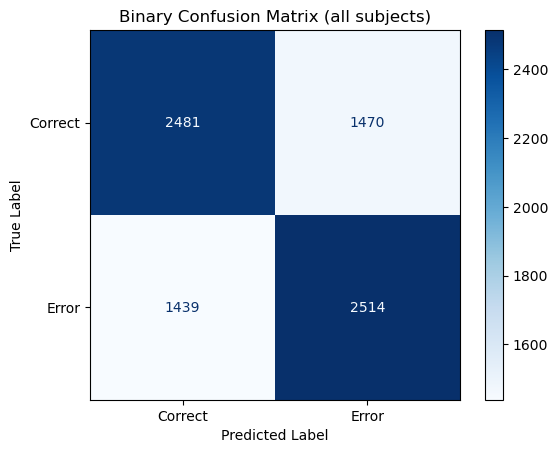

In [110]:

"""
Evaluate trained model performance on a held-out test set across subjects and perturbation magnitudes.

Workflow
--------
Per-magnitude analysis:
   - For each subject and perturbation magnitude (0°, 3°, 6°, 9°, 12°),
     computes the true positive rate or true negative rate (correct identification rate)

Per-subject analysis:
   - Aggregates accuracy, precision for each class, and macro F1-score for each subject.

All-subjects analysis:
   - Average tpr or tnr per magnitude, average accuracy, precision for each class, and macro F1-score

Confusion matrix:
   - Generates and displays a global binary confusion matrix at the frozen threshold.

"""

print(f'best trial: {study.best_trial.number}')
best_threshold = checkpoint['best_threshold']
best_threshold = 0.80
preds = (all_predicted > best_threshold).int()

save_study(all_predicted, f'results/{parameters.model_name}/predicted.pkl')
save_study(all_labels, f'results/{parameters.model_name}/labels.pkl')
save_study(all_magnitudes, f'results/{parameters.model_name}/magnitudes.pkl')
save_study(all_subjects, f'results/{parameters.model_name}/test_subjects.pkl')

true_labels_np      = all_labels.detach().cpu().numpy()
predicted_probs_np  = all_predicted.detach().cpu().numpy()
predicted_np        = preds.detach().cpu().numpy()
all_subjects_np     = all_subjects.detach().cpu().numpy()
all_magnitudes_np   = all_magnitudes.detach().cpu().numpy()
test_subjects_np    = np.unique(all_subjects_np)
unique_mags_np      = np.array(parameters.unique_magnitudes)

# ---- Containers ----
subject_wise_mag_wise_test_performance = {}           # per-magnitude per-subject TPR
subject_wise_test_performance = {}  # per-subject aggregate metrics

# ---- Per-magnitude, per-subject TPR (ErrP detection) ----
display(Markdown("## Per-magnitude, per-subject correct identification rate"))
for m in unique_mags_np:
    subject_wise_mag_wise_test_performance[int(m)] = {}
    for s in test_subjects_np:
        mask = (all_magnitudes_np == m) & (all_subjects_np == s)
        tpr, tnr, _ = evaluation(preds[mask], all_labels[mask])
        if m == 0:
            subject_wise_mag_wise_test_performance[int(m)][int(s)] = {"TPR": tnr}
            print(f'TPR for subject {s} and magnitude {m}: {tnr:.2f}')
        else:
            subject_wise_mag_wise_test_performance[int(m)][int(s)] = {"TPR": tpr}
            print(f'TPR for subject {s} and magnitude {m}: {tpr:.2f}')

save_study(subject_wise_mag_wise_test_performance, f'results/{parameters.model_name}/subject_wise_mag_wise_test_performance.pkl')

# ---- Per-subject aggregate metrics ----
display(Markdown('## Per-subject aggregate metrics'))
for s in test_subjects_np:
    mask = (all_subjects_np == s)
    _, _, acc = evaluation(preds[mask], all_labels[mask])
    precision = precision_score(true_labels_np[mask], predicted_np[mask], average=None, zero_division=0)
    recall    = recall_score(true_labels_np[mask],    predicted_np[mask], average=None, zero_division=0)
    f1   = f1_score(true_labels_np[mask],        predicted_np[mask], average='macro', zero_division=0)

    subject_wise_test_performance[int(s)] = {
        "acc": float(acc),
        "precision": precision,
        "recall":    recall,
        "f1":   float(f1),
    }
    
    print(f'Accuracy for subject {s}: {acc:.2f}')
    print(f'Precision [correct class] for subject {s}: {precision[0]:.2f}')
    print(f'Precision [error class] for subject {s}: {precision[1]:.2f}')
    print(f'f1 for subject {s}: {f1:.2f}')

save_study(subject_wise_test_performance, f'results/{parameters.model_name}/subject_wise_test_performance.pkl')

# ---- Aggregate metrics averaged across subjects ----
average_TPR_zerodeg = np.mean([v['TPR'].detach().cpu().numpy() for v in subject_wise_mag_wise_test_performance[int(0)].values()])
average_TPR_threedeg = np.mean([v['TPR'].detach().cpu().numpy() for v in subject_wise_mag_wise_test_performance[int(3)].values()])
average_TPR_sixdeg = np.mean([v['TPR'].detach().cpu().numpy() for v in subject_wise_mag_wise_test_performance[int(6)].values()])
average_TPR_ninedeg = np.mean([v['TPR'].detach().cpu().numpy() for v in subject_wise_mag_wise_test_performance[int(9)].values()])
average_TPR_twelvedeg = np.mean([v['TPR'].detach().cpu().numpy() for v in subject_wise_mag_wise_test_performance[int(12)].values()])

average_precision_correct = np.mean([v['precision'][0] for v in subject_wise_test_performance.values()])
average_precision_error = np.mean([v['precision'][1] for v in subject_wise_test_performance.values()])
average_f1= np.mean([v['f1'] for v in subject_wise_test_performance.values()])
average_acc= np.mean([v['acc'] for v in subject_wise_test_performance.values()])

test_performance = {
        "average_TPR_zerodeg": average_TPR_zerodeg,
        "average_TPR_threedeg": average_TPR_threedeg,
        "average_TPR_sixdeg":    average_TPR_sixdeg,
        "average_TPR_ninedeg":   average_TPR_ninedeg,
         "average_TPR_twelvedeg":   average_TPR_twelvedeg,
        "average_precision_correct": average_precision_correct,
        "average_precision_error": average_precision_error,
        "average_f1": average_f1,
        "average_acc": average_acc,
    }

save_study(test_performance, f'results/{parameters.model_name}/test_performance.pkl')

display(Markdown('## Average metrics across all subjects'))
print(f'TPR for magnitude 0: {average_TPR_zerodeg:.2f}')
print(f'TPR for magnitude 3: {average_TPR_threedeg:.2f}')
print(f'TPR for magnitude 6: {average_TPR_sixdeg:.2f}')
print(f'TPR for magnitude 9: {average_TPR_ninedeg:.2f}')
print(f'TPR for magnitude 12: {average_TPR_twelvedeg:.2f}')
print(f'Accuracy: {average_acc:.2f}')
print(f'Precision [correct class]: {average_precision_correct:.2f}')
print(f'Precision [error class]: {average_precision_error:.2f}')
print(f'f1: {average_f1:.2f}')


# ---- Global confusion matrix at the frozen threshold ----

cm = confusion_matrix(true_labels_np, predicted_np, labels=[0, 1])
class_names = ['Correct', 'Error']
disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp_binary.plot(cmap='Blues', values_format='d')
plt.title('Binary Confusion Matrix (all subjects)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.savefig(f'results/{parameters.model_name}/confusion_matrix_all_subjects.png', dpi=300, bbox_inches='tight')

In [51]:
import pkg_resources

with open("clean_requirements.txt", "w") as f:
    for dist in pkg_resources.working_set:
        try:
            line = f"{dist.project_name}=={dist.version}\n"
            f.write(line)
        except Exception:
            pass

/tmp/ipykernel_3406054/815861703.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## Archived code

In [ ]:
#CNN + GRU + attention mechanisms

class ErrPDetection_CNN_GRU_Attn(nn.Module):
    """
    1-D CNN frontend (spatial-temporal filtering) → GRU → attention pooling → classifier.

    Args
    ----
    input_size       : int
        Number of input features (channels).
    cnn_out_channels : int
        Number of filters in the convolutional layer.
    cnn_kernel_size  : int
        Kernel size for the convolutional filter.
    hidden_size      : int
        Dimensionality of GRU hidden state.
    num_layers       : int
        Number of GRU layers.
    dropout_rate     : float
        Dropout probability applied after GRU.
    output_size      : int
        Number of output classes.

    Input
    -----
    x : torch.Tensor [batch_size, sequence_length, input_size]

    Returns
    -------
    output : torch.Tensor [batch_size, output_size]
             Logits (apply sigmoid/softmax externally).
    """
    
    def __init__(self, input_size, cnn_out_channels, cnn_kernel_size,
                 hidden_size, num_layers, dropout_rate, output_size):
      
        super().__init__()

        self.cnn = nn.Conv1d(
            in_channels=input_size,
            out_channels=cnn_out_channels,
            kernel_size=cnn_kernel_size,
            padding=cnn_kernel_size // 2  # 'same' padding
        )
        self.bn = nn.BatchNorm1d(cnn_out_channels)
        self.relu = nn.ReLU()

        # GRU input size = cnn_out_channels (features per timepoint)
        self.gru = nn.GRU(
            input_size=cnn_out_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.dropout = nn.Dropout(dropout_rate)

        # Attention layer
        self.attention_layer = nn.Linear(hidden_size, 1)

        # Final classifier
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # permute needed to match input size: x: [batch, channels, time]
        x = x.permute(0, 2, 1) 
        x = self.cnn(x)                     # [batch, cnn_out_channels, time]
        x = self.bn(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)             # [batch, time, cnn_out_channels] → GRU input

        gru_out, _ = self.gru(x)           # [batch, time, hidden_size]
        gru_out = self.dropout(gru_out)

        attn_scores = self.attention_layer(gru_out)  # [batch, time, 1]
        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * gru_out, dim=1)  # [batch, hidden_size]

        output = self.fc(context)          # [batch, output_size]
        return output

In [ ]:
# Dataset loading

import gc 
def deref_all_refs(group, ref_container):
    return [group[ref[0]][:] for ref in ref_container]

def load_neuromod_data():
    """
    Reads 'discrete_errp.mat' (HDF5) and concatenates trials across subjects.

    Returns
    -------
    rotation_dataset_all_subjects : np.ndarray [sequence length, channels, num trials]
    labels_all_subjects           : np.ndarray [1, num trials]
    magnitudes_all_subjects       : np.ndarray [1, num trials]
    """
    
    with h5py.File('data/discrete_errp.mat', 'r') as discrete_file,  \
         h5py.File('data/continuous_errp.mat', 'r') as continous_file:
        
        continuous_group = continous_file['continuous_errp']
        discrete_group = discrete_file['discrete_errp']
    
        continuous_data_list = deref_all_refs(continuous_group, continuous_group['data'])
        discrete_data_list = deref_all_refs(discrete_group, discrete_group['data'])
        continuous_label_list = deref_all_refs(continuous_group, continuous_group['label'])
        discrete_label_list = deref_all_refs(discrete_group, discrete_group['label'])
    
        # Combine
        all_data = continuous_data_list + discrete_data_list
        all_labels = continuous_label_list + discrete_label_list
        #all_data = discrete_data_list
        #all_labels = discrete_label_list
        neuromod_dataset = [x.astype(np.float32) for x in all_data]
        labels = [x.astype(np.uint8) for x in all_labels]
    
        del all_data, all_labels
        gc.collect()
    
        neuromod_dataset_all_subjects = np.concatenate(neuromod_dataset, axis=0)
        labels_all_subjects = np.concatenate(labels, axis=1)
    
        return neuromod_dataset_all_subjects, labels_all_subjects

In [ ]:
    if parameters.use_neuromod_dataset is True:
        rotation_dataset_all_subjects, labels_all_subjects = load_neuromod_data()
        labels_all_subjects = np.squeeze(labels_all_subjects)
        task_labels_all_subjects = 2 * np.ones(labels_all_subjects.size) 
        task_labels_all_subjects = np.squeeze(task_labels_all_subjects)
        magnitudes_all_subjects = np.ones(labels_all_subjects.size)
        magnitudes_all_subjects = np.squeeze(magnitudes_all_subjects)
        rotation_dataset_all_subjects = rotation_dataset_all_subjects[:,RNN_features_neuromod_dataset,:]
        
    if parameters.use_multiple_datesets is True:
        rotation_dataset_all_subjects, labels_all_subjects, magnitudes_all_subjects, subjects_index = load_combined_data()
        labels_all_subjects = np.squeeze(labels_all_subjects)
        magnitudes_all_subjects = np.squeeze(magnitudes_all_subjects)
        task_labels_PL = np.ones(labels_all_subjects.size)
        rotation_dataset_all_subjects = rotation_dataset_all_subjects[:,RNN_features_PL_dataset,:]

        
        neuromod_dataset_all_subjects, neuromod_labels_all_subjects = load_neuromod_data()
        task_labels_neuromod = 2 * np.ones(neuromod_labels_all_subjects.size)
        neuromod_labels_all_subjects = np.squeeze(neuromod_labels_all_subjects)
        labels_all_subjects = np.concatenate((labels_all_subjects, neuromod_labels_all_subjects))
        magnitudes_temp = np.ones(neuromod_labels_all_subjects.size)
        magnitudes_all_subjects = np.concatenate((magnitudes_all_subjects, magnitudes_temp))
        task_labels_all_subjects = np.concatenate((task_labels_PL, task_labels_neuromod))
        neuromod_dataset_all_subjects = neuromod_dataset_all_subjects[:,RNN_features_neuromod_dataset,:]
        rotation_dataset_all_subjects = np.concatenate((rotation_dataset_all_subjects, neuromod_dataset_all_subjects))


In [ ]:
#Bidirectional GRU + attention mechanisms

class ErrPDetectionRNNModel_with_att_bidir(nn.Module):
    """
    Bidirectional GRU + temporal attention.
    """
    
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, output_size):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True 
        )
        self.dropout = nn.Dropout(dropout_rate)
        
        # Attention layer takes 2 * hidden_size 
        self.attention_layer = nn.Linear(2 * hidden_size, 1)
        
        # Final classifier layer also takes 2 * hidden_size
        self.fc = nn.Linear(2 * hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gru_output, _ = self.gru(x)  
        gru_output = self.dropout(gru_output)

        # Attention weights over time steps
        attn_scores = self.attention_layer(gru_output)  # [batch_size, seq_len, 1]
        attn_weights = F.softmax(attn_scores, dim=1)    

        context = torch.sum(attn_weights * gru_output, dim=1)  # [batch_size, 2 * hidden_size]

        # Final classification
        output = self.fc(context)  # [batch_size, output_size]
        return output  